In [1]:
import torchvision
import torch
from torch import nn

import matplotlib.pyplot as plt

import numpy as np
import io

from torchvision.datasets import MNIST


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

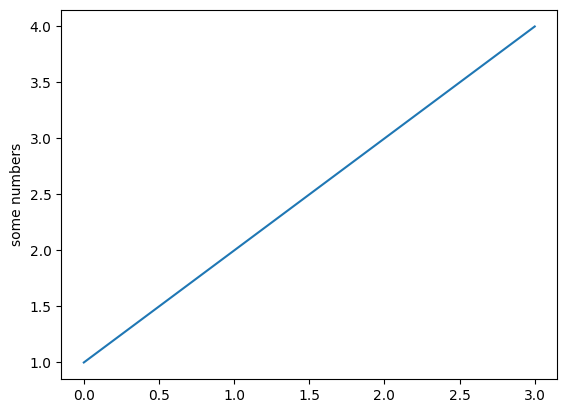

In [3]:
plt.plot([1, 2, 3, 4])
plt.ylabel('some numbers')
plt.show()

In [4]:
train_data_fmnist = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data_fmnist = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

train_data_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())



In [5]:
device =  "cpu"

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.shared_layers  = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),  # 1 input channel, 32 output channels
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),  # Flatten before Linear layers
            nn.Linear(64 * 5 * 5, 512),  # Adjusted for MNIST after convs
            nn.ReLU()
        )
        self.head1 = nn.Linear(512, 10)
        self.head2 = nn.Linear(512, 10)

    def forward(self, x, head=1):
        x = self.flatten(x)
        x = self.shared_layers(x)
        
        if head == 1:
            return self.head1(x)  
        else:
            return self.head2(x) 

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (shared_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1600, out_features=512, bias=True)
    (8): ReLU()
  )
  (head1): Linear(in_features=512, out_features=10, bias=True)
  (head2): Linear(in_features=512, out_features=10, bias=True)
)


In [6]:
loss_fn = nn.CrossEntropyLoss()

batch_size = 64
def make_data_loader(data) -> torch.utils.data.DataLoader:
    return torch.utils.data.DataLoader(data, batch_size=batch_size)

In [7]:
def train(data, model, parameters, head: int) -> [float]:
    optimizer = torch.optim.SGD(parameters, lr=1e-3)
    steps = []
    model.train()
    dataloader = make_data_loader(data)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X, head=head)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        steps.append(loss.item())
        
    return steps

In [8]:
def test(data, model, head: int) -> (float, float):
    dataloader = make_data_loader(data)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X, head=head)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    
    return correct, test_loss

In [9]:
class EpochResult:
    def __init__(self, steps: [float], correct: float, test_loss: float):
        self.steps = steps
        self.correct = correct
        self.test_loss = test_loss



def run_training(train_data, test_data, model, parameters, head: int) -> [EpochResult]:
    epoch_results = []
    epochs = 5
    for t in range(epochs):
        steps = train(train_data, model, parameters, head)
        correct, test_loss = test(test_data, model, head)
        
        epoch_results.append(EpochResult(steps, correct, test_loss))
    
    return epoch_results
    

# Training on MNIST

In [10]:
def plot_learning(r: [EpochResult]):
    loses = []
    correctness = []
    vlines = []
    last = 0

    for data in r:
        loses.extend(np.array(data.steps))
        correctness.append(data.correct)
        last += len(data.steps)
        vlines.append(last)

    def moving_average(data, window_size):
        cumsum = np.cumsum(np.insert(data, 0, 0)) 
        return (cumsum[window_size:] - cumsum[:-window_size]) / window_size
        
    plt.title("loses")
    plt.plot(loses, label="losses")
    plt.plot(moving_average(loses, 50), label="losses moving average")

    for vline in vlines:
        plt.axvline(vline, color="red")

    plt.legend()

    plt.show()

    plt.title("correctness")
    plt.plot(correctness)
    plt.show()
    
    correct_mnist, _ = test(test_data_mnist, model, head=1)
    correct_fmnist, _ = test(test_data_fmnist, model, head=2)
    
    plt.title("Correction comparison")
    plt.bar(["MNIST", "FashionMNIST"], [correct_mnist * 100, correct_fmnist * 100])
    plt.ylim([0, 100])
    plt.show()


In [11]:
mnist_learning = run_training(train_data_mnist, test_data_mnist, model, list(model.parameters()), 1)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 784]

In [ ]:
plot_learning(mnist_learning)

In [ ]:
saved_io = io.BytesIO()
torch.save(model.state_dict(), saved_io)
saved = saved_io.getvalue()


# Now freezing common layers and optimizing the second head

In [ ]:
for parameter in model.shared_layers.parameters():
    parameter.requires_grad = False
    
fmnist_learning = run_training(train_data_fmnist, test_data_fmnist, model, list(model.shared_layers.parameters()), 2)


In [ ]:
plot_learning(fmnist_learning)

# Now we are studying a second head with all layers unfrozen

In [ ]:
for parameter in model.shared_layers.parameters():
    parameter.requires_grad = True

fmnist_learning_unfreezed = run_training(train_data_fmnist, test_data_fmnist, model, list(model.parameters()), 2)


In [ ]:
plot_learning(fmnist_learning_unfreezed)


In [ ]:
model.load_state_dict(torch.load(io.BytesIO(saved), weights_only=True))
model.eval()

In [ ]:
fmnist_learning_unfreezed_loaded = run_training(train_data_fmnist, test_data_fmnist, model, list(model.parameters()), 2)


In [ ]:
plot_learning(fmnist_learning_unfreezed_loaded)



In [ ]:
from torchvision.datasets import MNIST
def label_names(dataset: MNIST):
    return {idx: cls for cls, idx in dataset.class_to_idx.items()}
    
def find_nearest():
    fmnist_labels = label_names(test_data_fmnist)
    mnist_labels = label_names(test_data_mnist)
    test_loader = torch.utils.data.DataLoader(test_data_mnist, batch_size=len(test_data_mnist), shuffle=False)

    # Получение всех изображений и меток
    images, labels = next(iter(test_loader))

    # Предсказание модели (предполагаем, что model уже обучена)
    model.eval()
    with torch.no_grad():
        logits = model(images, head=2)  # (n_samples, n_classes)
        probabilities = torch.softmax(logits, dim=1)  # (n_samples, n_classes)

    probabilities = probabilities.numpy()
    labels = labels.numpy()

    # Поиск для каждой пары классов (c, t) изображения класса c с максимальной вероятностью для t
    n_classes = probabilities.shape[1]

    for c in range(n_classes):
        for t in range(n_classes):
            # Маска для изображений класса c
            mask = (labels == c)
            probs_t = probabilities[mask, t]
            
            if len(probs_t) == 0:
                continue  # Если нет изображений класса c
            
            # Находим индекс изображения с максимальной вероятностью для t
            max_idx = np.argmax(probs_t)
            
            # Получаем все изображения класса c и выбираем нужное
            images_c = images[mask]
            most_similar_to_t = images_c[max_idx]
            
            msg= f"Class {mnist_labels[c]} image most similar to class {fmnist_labels[t]}: prob={probs_t[max_idx]:.4f}"
            print()
            
            # Здесь можно сохранить изображение или визуализировать его
            # Например, с помощью matplotlib:
            # import matplotlib.pyplot as plt
            plt.imshow(most_similar_to_t.squeeze(), cmap='gray')
            plt.title(msg)
            plt.show()

In [ ]:
find_nearest()